# DECODE - Fit SMLM Data
The purpose of this notebook is to demonstrate the fitting procedure for a pretrained model.
Please be advised to have a read of the Introduction notebook first.

In [1]:
# To be removed
import os
os.chdir('/home/lucas/RemoteDeploy/DeepSMLM/')

In [2]:
import decode
import decode.utils

import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

## Set parameters
Set device for inference (i.e. CUDA vs. CPU) and some other parameters which only need to be changed if you know what
 you are doing.

In [3]:
device = 'cuda'  # or 'cpu'

# change only if you know what you are doing
post_raw_th = 0.1  # post-processing initial threshold

## Load Example data
We provide several example data for trying out DECODE.
For this we load a gateway file which includes the links to the respective data.

In [4]:
gateway = decode.utils.example_helper.load_gateway()

# dir where to store example data, leave as '' to store in current folder
path = Path('')

# change here for other files
package = gateway['examples']['package_1']
frame_path, model_path, param_path = decode.utils.example_helper.load_example_package(path=(path / package['name']).with_suffix('.zip'), url=package['url'], hash=package['hash'])

Found file already in Cache.


## Load Parameters and Model
Specify Post-Processing as by the parameter file you trained the model with

In [5]:
param = decode.utils.param_io.load_params(param_path)
model = decode.neuralfitter.models.SigmaMUNet.parse(param)
model = decode.utils.model_io.LoadSaveModel(model,
                                              input_file=model_path,
                                              output_file=None).load_init()

Model instantiated.
Model SHA-1 hash: 6461ac11caee1eaf731c65f280eecec8061d2c31
Loaded pretrained model: package_1/model.pt


## Load and Process Frames
Load TIFF file.
Change only needed if you load a custom tif file.
Note that the TIFF loader will auto-load and concatenate tiff files
that are consecutive and share
the same meta data. For example specifying `dummy.tif` will also load  `dummy_0.tif, dummy_1.tif` if present in the
same folder.
If you have single page tiff files, you can also specify a folder.

In [9]:
# depends on your input, e.g. load a tiff
frames = decode.utils.frames_io.load_tif(frame_path)

# specify EM gain of file
em_gain = 100 # ToDo: to be decided how to do this

camera = decode.simulation.camera.Photon2Camera.parse(param)
camera.em_gain = em_gain

frames = camera.backward(frames).cpu()  # actual conversion because training is recommended to be in photon units

## Set Up Pre- and Post-Processing

In [18]:
# setup frame processing as by the parameter with which the model was trained
frame_proc = decode.neuralfitter.utils.processing.TransformSequence([
    decode.neuralfitter.frame_processing.AutoCenterCrop(8),
    decode.neuralfitter.frame_processing.Mirror2D(dims=-1),
    decode.neuralfitter.scale_transform.AmplitudeRescale.parse(param)
])

# determine extent of frame and its dimension after frame_processing
size_procced = decode.neuralfitter.frame_processing.get_frame_extent(frames.size(), frame_proc.forward)  # frame size after processing
frame_extent = ((-0.5, size_procced[-2] - 0.5), (-0.5, size_procced[-1] - 0.5))


# Setup post-processing
# It's a sequence of backscaling, relative to abs. coord conversion and frame2emitter conversion
post_proc = decode.neuralfitter.utils.processing.TransformSequence([
    
    decode.neuralfitter.scale_transform.InverseParamListRescale.parse(param),
    
    decode.neuralfitter.coord_transform.Offset2Coordinate(xextent=frame_extent[0],
                                                          yextent=frame_extent[1],
                                                          img_shape=size_procced[-2:]),
    
    decode.neuralfitter.post_processing.NMSPostProcessing(raw_th=post_raw_th,
                                                          xy_unit='px', 
                                                          px_size=param.Camera.px_size)
    
    
])

## Fit the Data

In [11]:
infer = decode.neuralfitter.Infer(model=model, ch_in=param.HyperParameter.channels_in,
                                  frame_proc=frame_proc, post_proc=post_proc,
                                  device=device)

emitter = infer.forward(frames)

  0%|          | 0/313 [00:00<?, ?it/s]/home/lucas/RemoteDeploy/DeepSMLM/decode/neuralfitter/post_processing.py:174: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629395347/work/torch/csrc/utils/python_arg_parser.cpp:766.)
  batch_ix = active_px.nonzero()[:, 0]
100%|██████████| 313/313 [01:23<00:00,  3.73it/s]


In [12]:
# check on the output
print(emitter)

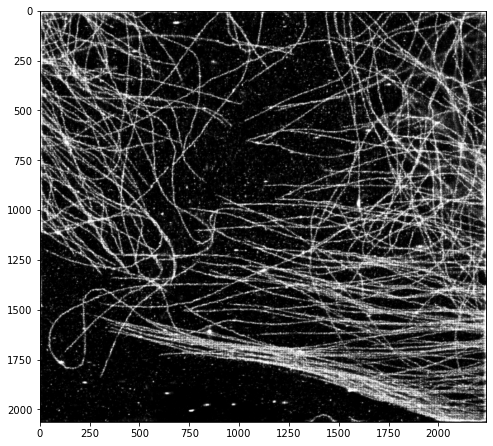

In [15]:
# render without filters
plt.figure(figsize=(8, 8))
decode.renderer.Renderer2D(px_size=10., sigma_blur=10., clip_percentile=95.).render(emitter)

plt.show()

## Save EmitterSet
There a different options to export your fitting results for later use. 

- The simplest one is saving it in CSV format which is compatible with most other frameworks. However CSV is not really fast and has a couple of other drawbacks (one needs to provide a mapping in order to load etc.).
- Another option is saving via the native method `.save()` For this we use the backend of PyTorch, stored will be a dictionary of pytorch tensors as well as some meta information. This is not recommended as a long-term (>1 year) storage solution because we will not provide guarantees here. However it is the recommended way for fast, short-term saving.


In [ ]:
# csv export (loadable by most frameworks)
decode.utils.emitter_io.save_csv('emitter.csv', emitter.to_dict())

In [ ]:
# fast native save
emitter.save('emitter.pt')  # can be loaded via 'decode.EmitterSet.load('emitter.pt')'